In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget

# locals
import utils as ut
reload(ut)

2022-12-22 11:45:00.825792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 11:45:00.958244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-12-22 11:45:00.958271: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-22 11:45:00.984300: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-22 11:45:02.3398

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
clusterPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/clusters.csv"
cf = pd.read_parquet(clusterPath)
print(cf.shape)
print(cf['cellType'].unique())
cf.head()

(427882, 7)
['Macrophages' 'B cells' 'Monocytes' 'NK cells' 'Dendritic cells'
 'T cells' 'Stromal cells']


,gene,scores,pvals,logfoldchanges,clusterId,key,cellType
0,H2-EB1,36.343353,4.575346e-181,3.564091,1,ND,Macrophages
1,H2-AA,35.311523,4.761517e-183,3.430534,1,ND,Macrophages
2,H2-AB1,34.411163,2.815112e-177,3.234597,1,ND,Macrophages
3,CD74,33.910587,2.451588e-177,3.302062,1,ND,Macrophages
4,H2-DMA,31.695400,2.991793e-123,2.667091,1,ND,Macrophages


In [3]:
"""load scRNA"""
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

rna = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        rna[key] = data
    
print("done")

done


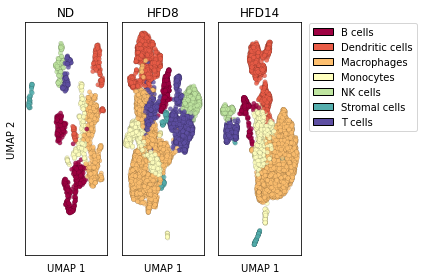

In [4]:
# plot clusters using individual embeddings
# shows how well defined the clusters are at a single time point
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'

keys = ['ND', 'HFD8', 'HFD14']

ncolors = cf['cellType'].nunique()
ctypes = sorted(cf['cellType'].unique())

colordict = dict(zip(ctypes, ut.ncolor(ncolors, cmap='Spectral')))

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()


for i, key in enumerate(keys):
    data = rna[key]
        
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    embedding = data.obsm['X_umap']
    
    # get coloring
    c = ['k'] * len(embedding)
    handles = []
    
    for ctype in ctypes:
        mask = (cf['cellType'] == ctype) & (cf['key'] == key)
        cids = cf[mask]['clusterId'].unique()
        c = np.where(clusterIds.isin(cids), colordict[ctype], c)
        
        handle = mpatches.Patch(color=colordict[ctype], 
                                ec='k', 
                                label=ctype)
        handles.append(handle)
        
    
    axs[i].scatter(embedding[:, 0] , 
                   embedding[:, 1] , 
                   c=c,
                   edgecolor="k",
                   linewidth=0.1,
                   s=20,
                   alpha=0.8,)
    
        
    axs[i].set_title(key)
    axs[i].set_xlabel("UMAP 1")
    
    if i == 0:
        axs[i].set_ylabel("UMAP 2")
    
    _ = axs[i].set_xticks([])
    _ = axs[i].set_yticks([])

    
plt.legend(handles=handles, bbox_to_anchor=(1.04, 1.02))
plt.tight_layout()

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']

['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2']



,cellType,proportion,color,key
0,B cells,0.287074,#9e0142,ND
1,Dendritic cells,0.113402,#e95c47,ND
2,Macrophages,0.284695,#fdbf6f,ND
3,Monocytes,0.138779,#ffffbe,ND
4,NK cells,0.076130,#bfe5a0,ND


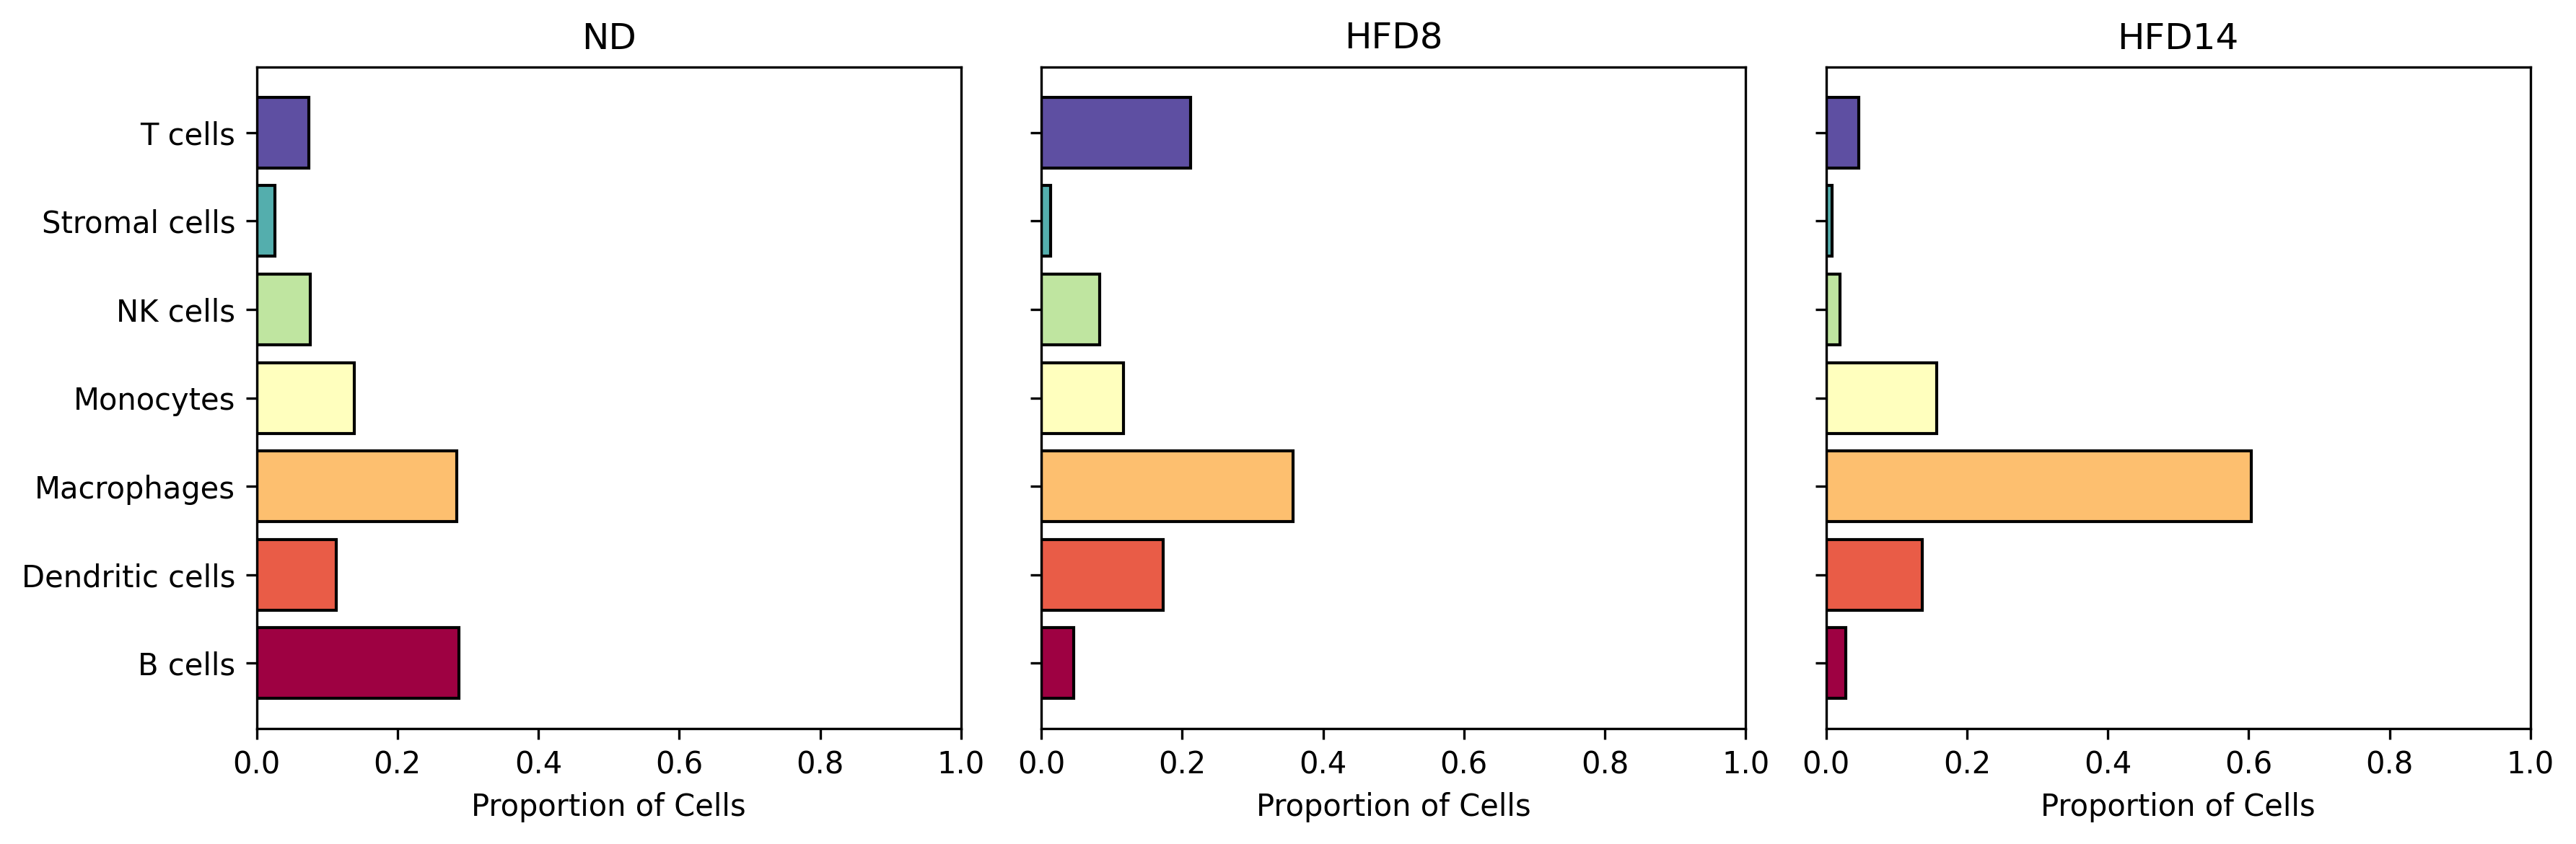

In [5]:
keys = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['figure.facecolor'] = 'w'


keys = ['ND', 'HFD8', 'HFD14']

fig, axs = plt.subplots(1, 3, sharey=True)
axs = axs.ravel()

res = []

for i, key in enumerate(keys):
    data = rna[key]
    
    clusterCount = pd.DataFrame(data.obs[runKey].astype(int).value_counts(normalize=True))
    clusterCount.columns = ['proportion'] 
    clusterCount['clusterId'] = clusterCount.index + 1
    
    # add cell types
    mask = (cf['key'] == key)
    ctdf = cf[mask]
    
    ctdf = ctdf.drop_duplicates(subset=['cellType', 'clusterId'])
    ctMapper = dict(zip(ctdf['clusterId'], ctdf['cellType']))
    
    clusterCount['cellType'] = clusterCount['clusterId'].map(ctMapper)
    
    grped = clusterCount.groupby('cellType')['proportion'].sum()
    grped = grped.sort_index(ascending=False).reset_index()
    
    grped['color'] = grped['cellType'].map(colordict)
    grped['key'] = key
    
    grped = grped.sort_values(by='cellType')
    print(grped['color'].to_list())
    print()
    
    res.append(grped)
    
    axs[i].barh(grped['cellType'],
             grped['proportion'],
             color=grped['color'],
             edgecolor='k')
    
    axs[i].set_xlabel('Proportion of Cells')
    axs[i].set_title(key)
    axs[i].set_xlim([0, 1])

plt.tight_layout()


res = pd.concat(res,ignore_index=True)
res.head()

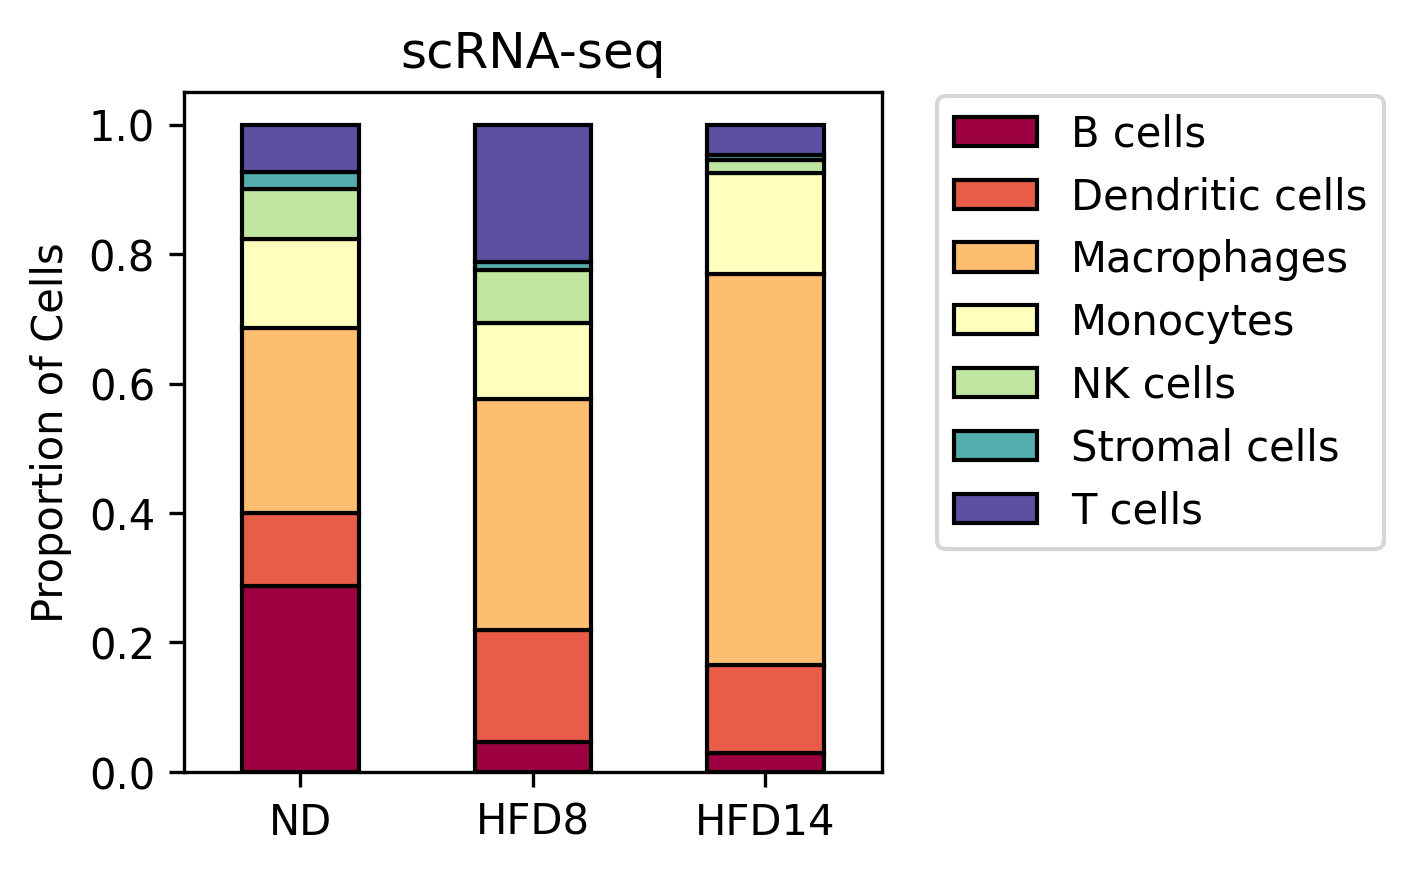

In [6]:
res = res.sort_values(by='key', ascending=False)
res2 = pd.pivot_table(res, values='proportion', index=['cellType'], columns='key').reset_index()
res2 = res2.set_index('cellType')
# res2.columns = ['ND', 'HFD8', 'HFD14']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
plt.rcParams['figure.facecolor'] = 'w'

# res = res.set_index('cellType')
res2.T.plot(kind='bar', stacked=True, edgecolor='k', color=['#9e0142', '#e95c47', '#fdbf6f', '#ffffbe', '#bfe5a0', '#54aead', '#5e4fa2'])
plt.legend(bbox_to_anchor=(1.05, 1.025))
plt.ylabel('Proportion of Cells')
_ = plt.xticks(rotation=0)
plt.xlabel("")
plt.title("scRNA-seq")
plt.gca().invert_xaxis()

In [7]:
df = pd.DataFrame({'High Temp': [28, 30, 34, 38, 45, 42,
                                 38, 35, 32, 28, 25, 21],
                   'Low Temp': [22, 26, 30, 32, 41, 38,
                                32, 31, 28, 22, 15, 15],
                   'Avg Temp': [25, 28, 32, 35, 43, 40,
                                35, 33, 30, 25, 20, 18]},
                  index=['Jan', 'Feb', 'Mar', 'Apr', 'May',
                         'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                         'Nov', 'Dec'])

df.head()

,High Temp,Low Temp,Avg Temp
Jan,28,22,25
Feb,30,26,28
Mar,34,30,32
Apr,38,32,35
May,45,41,43


In [8]:
res.head()

,cellType,proportion,color,key
0,B cells,0.287074,#9e0142,ND
1,Dendritic cells,0.113402,#e95c47,ND
2,Macrophages,0.284695,#fdbf6f,ND
3,Monocytes,0.138779,#ffffbe,ND
4,NK cells,0.076130,#bfe5a0,ND
